# Import data and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pickle
import scripts

tree_data = pd.read_csv('../data/covtype.data', header=None)
tree_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_To_Hydrology',
             'Vertical_To_Hydrology', 'Horizontal_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
             'Horizontal_To_Fire'] + \
            [f'Wilderness_Area_{i}' for i in range(4)] + \
            [f'Soil_Type_{i}' for i in range(40)] + \
            ['Cover_Type']

# print(tree_data.describe())
tree_data.columns = tree_cols
print("Nan values in dataset:", tree_data.isna().sum().sum())
print(tree_data.head())

2025-12-03 16:19:44.502520: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 16:19:44.542929: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 16:19:46.737920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Nan values in dataset: 0
   Elevation  Aspect  Slope  Horizontal_To_Hydrology  Vertical_To_Hydrology  \
0       2596      51      3                      258                      0   
1       2590      56      2                      212                     -6   
2       2804     139      9                      268                     65   
3       2785     155     18                      242                    118   
4       2595      45      2                      153                     -1   

   Horizontal_To_Roadways  Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0                     510            221             232            148   
1                     390            220             235            151   
2                    3180            234             238            135   
3                    3090            238             238            122   
4                     391            220             234            150   

   Horizontal_To_Fire  ...  Soil_Type_31  Soil_Ty

## Split training/testing data

In [2]:
x_tree = tree_data.drop('Cover_Type', axis=1)
y_tree = tree_data['Cover_Type']

x_train, x_test, y_train, y_test = train_test_split(x_tree, y_tree, test_size=0.2)


x_underSampled, y_underSampled = RandomUnderSampler(random_state=42, sampling_strategy='majority').fit_resample(x_train, y_train)
x_underSampled2, y_underSampled2 = RandomUnderSampler(random_state=42, sampling_strategy='majority').fit_resample(x_underSampled, y_underSampled)
x_even, y_even = RandomUnderSampler(random_state=42, sampling_strategy='auto').fit_resample(x_train, y_train)

x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

x_underSampled = x_underSampled.to_numpy()
y_underSampled = y_underSampled.to_numpy()

x_underSampled2 = x_underSampled2.to_numpy()
y_underSampled2 = y_underSampled2.to_numpy()

x_even = x_even.to_numpy()
y_even = y_even.to_numpy()

data = tree_data.to_numpy()

## Class Distribution

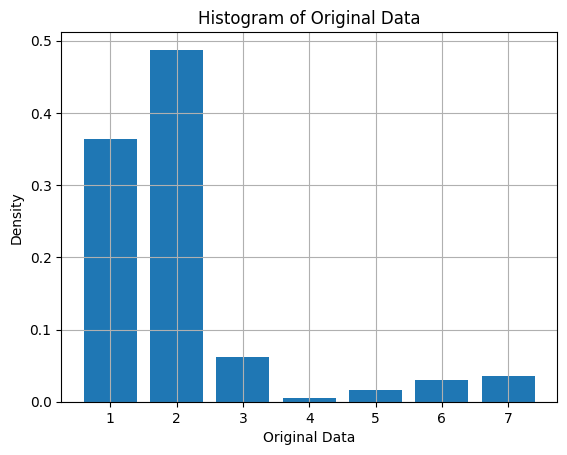

In [3]:
scripts.plot_histogram(y_tree, label='Original Data')

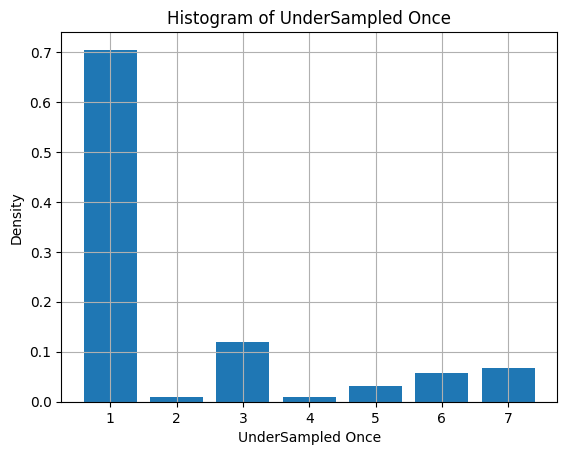

In [4]:
scripts.plot_histogram(pd.Series(y_underSampled), label='UnderSampled Once')

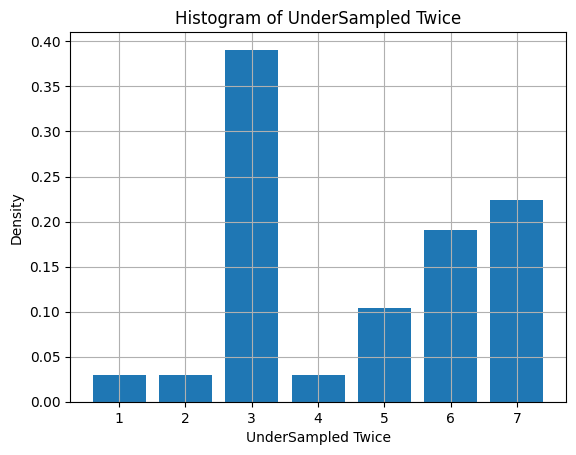

In [5]:
scripts.plot_histogram(pd.Series(y_underSampled2), label='UnderSampled Twice')

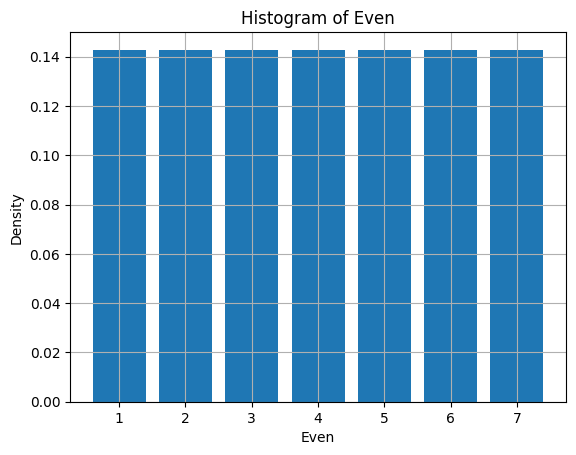

In [6]:
scripts.plot_histogram(pd.Series(y_even), label='Even')

## Scaling Dataset

In [7]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_underSampled[:, :10])

dataScaled = np.concatenate((scaled, x_underSampled[:,10:54]), axis=1)

x_Scaled_train, x_Scaled_test, y_Scaled_train, y_Scaled_test = train_test_split(dataScaled, y_underSampled.reshape(-1, 1), test_size=0.2)

In [8]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_train[:, :10])

dataScaled = np.concatenate((scaled, x_train[:,10:54]), axis=1)

x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(dataScaled, y_train.reshape(-1, 1), test_size=0.2)

In [9]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_underSampled[:, :10])

dataScaled = np.concatenate((scaled, x_underSampled[:,10:54]), axis=1)

x_underSampled_train_scaled, x_underSampled_test_scaled, y_underSampled_train_scaled, y_underSampled_test_scaled = train_test_split(dataScaled, y_underSampled.reshape(-1, 1), test_size=0.2)

In [10]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_underSampled2[:, :10])

dataScaled = np.concatenate((scaled, x_underSampled2[:,10:54]), axis=1)

x_underSampled2_train_scaled, x_underSampled2_test_scaled, y_underSampled2_train_scaled, y_underSampled2_test_scaled = train_test_split(dataScaled, y_underSampled2.reshape(-1, 1), test_size=0.2)

In [11]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_even[:, :10])

dataScaled = np.concatenate((scaled, x_even[:,10:54]), axis=1)

x_even_train_scaled, x_even_test_scaled, y_even_train_scaled, y_even_test_scaled = train_test_split(dataScaled, y_even.reshape(-1, 1), test_size=0.2)

## AdaBoost with balanced class weights

In [12]:
ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=13, class_weight='balanced'), n_estimators=100)
ab.fit(x_Scaled_train, y_Scaled_train.ravel())
print("Z Scaled Test Accuracy: ", ab.score(x_Scaled_test, y_Scaled_test))


Z Scaled Test Accuracy:  0.9801508947685657


## AdaBoost

In [13]:

ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=13), n_estimators=100)
ab.fit(x_Scaled_train, y_Scaled_train.ravel())
print("Z Scaled Test Accuracy: ", ab.score(x_Scaled_test, y_Scaled_test))


Z Scaled Test Accuracy:  0.9801716791719494


## GridSearch with balanced class weights

In [14]:
mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)
param_grid = {"estimator": [DecisionTreeClassifier(max_depth=7, class_weight='balanced'), DecisionTreeClassifier(max_depth=9, class_weight='balanced'), \
                            DecisionTreeClassifier(max_depth=11, class_weight='balanced'), DecisionTreeClassifier(max_depth=13, class_weight='balanced'), \
                            DecisionTreeClassifier(max_depth=15, class_weight='balanced'), DecisionTreeClassifier(max_depth=17, class_weight='balanced')], \
"n_estimators": [50, 100]}

model_ABB = AdaBoostClassifier()

In [15]:
# Orginal Data
grid_searchABB = GridSearchCV(model_ABB, param_grid, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchABB.fit(x_train_scaled, y_train_scaled.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 1/3; 1/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50;, score=0.516 total time=  44.4s
[CV 2/3; 1/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 2/3; 1/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50;, score=0.497 total time=  44.2s
[CV 3/3; 1/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 3/3; 1/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50;, score=0.523 total time=  43.4s
[CV 1/3; 2/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=100
[CV 1/3; 2/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_d

,estimator,AdaBoostClassifier()
,param_grid,"{'estimator': [DecisionTreeC..., max_depth=7), DecisionTreeC..., max_depth=9), ...], 'n_estimators': [50, 100]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [16]:
# Under Sampled Once
grid_searchABB_1 = GridSearchCV(model_ABB, param_grid, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchABB_1.fit(x_underSampled_train_scaled, y_underSampled_train_scaled.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 1/3; 1/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50;, score=0.701 total time=  18.0s
[CV 2/3; 1/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 2/3; 1/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50;, score=0.712 total time=  17.8s
[CV 3/3; 1/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 3/3; 1/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50;, score=0.742 total time=  17.7s
[CV 1/3; 2/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=100
[CV 1/3; 2/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_d

,estimator,AdaBoostClassifier()
,param_grid,"{'estimator': [DecisionTreeC..., max_depth=7), DecisionTreeC..., max_depth=9), ...], 'n_estimators': [50, 100]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [17]:
# UnderSampled Twice
grid_searchABB_2 = GridSearchCV(model_ABB, param_grid, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchABB_2.fit(x_underSampled2_train_scaled, y_underSampled2_train_scaled.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 1/3; 1/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50;, score=0.774 total time=   5.4s
[CV 2/3; 1/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 2/3; 1/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50;, score=0.775 total time=   5.4s
[CV 3/3; 1/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 3/3; 1/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50;, score=0.766 total time=   5.4s
[CV 1/3; 2/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=100
[CV 1/3; 2/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_d

,estimator,AdaBoostClassifier()
,param_grid,"{'estimator': [DecisionTreeC..., max_depth=7), DecisionTreeC..., max_depth=9), ...], 'n_estimators': [50, 100]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [18]:
# Even
grid_searchABB_even = GridSearchCV(model_ABB, param_grid, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchABB_even.fit(x_even_train_scaled, y_even_train_scaled.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 1/3; 1/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50;, score=0.730 total time=   1.3s
[CV 2/3; 1/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 2/3; 1/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50;, score=0.748 total time=   1.3s
[CV 3/3; 1/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50
[CV 3/3; 1/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=50;, score=0.731 total time=   1.3s
[CV 1/3; 2/12] START estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=7), n_estimators=100
[CV 1/3; 2/12] END estimator=DecisionTreeClassifier(class_weight='balanced', max_d

,estimator,AdaBoostClassifier()
,param_grid,"{'estimator': [DecisionTreeC..., max_depth=7), DecisionTreeC..., max_depth=9), ...], 'n_estimators': [50, 100]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


## Best Models from Grid Search

In [19]:
print("Original Data: ", grid_searchABB.best_params_, grid_searchABB.best_score_)
print("UnderSampled Once: ", grid_searchABB_1.best_params_, grid_searchABB_1.best_score_)
print("UnderSampled Twice: ", grid_searchABB_2.best_params_, grid_searchABB_2.best_score_)
print("Even: ", grid_searchABB_even.best_params_, grid_searchABB_even.best_score_)

Original Data:  {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=17), 'n_estimators': 100} 0.9288636135106421
UnderSampled Once:  {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=15), 'n_estimators': 100} 0.9498036514786613
UnderSampled Twice:  {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=15), 'n_estimators': 100} 0.9278644333021081
Even:  {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=13), 'n_estimators': 100} 0.8299013445778435


## GridSearch without class weights

In [20]:
mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)
param_grid = {"estimator": [DecisionTreeClassifier(max_depth=7), DecisionTreeClassifier(max_depth=9), \
                            DecisionTreeClassifier(max_depth=11), DecisionTreeClassifier(max_depth=13), \
                            DecisionTreeClassifier(max_depth=15), DecisionTreeClassifier(max_depth=17)], \
"n_estimators": [50, 100]}

model_ab = AdaBoostClassifier()

In [21]:
grid_searchAB = GridSearchCV(model_ab, param_grid, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchAB.fit(x_train_scaled, y_train_scaled.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 1/3; 1/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.527 total time=  37.5s
[CV 2/3; 1/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 2/3; 1/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.517 total time=  37.8s
[CV 3/3; 1/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 3/3; 1/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.533 total time=  37.4s
[CV 1/3; 2/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 1/3; 2/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.526 total time= 1.3min
[CV 2/3; 2/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 2/3; 2/12] END estimator=DecisionTreeClassifier(max_

,estimator,AdaBoostClassifier()
,param_grid,"{'estimator': [DecisionTreeC...r(max_depth=7), DecisionTreeC...r(max_depth=9), ...], 'n_estimators': [50, 100]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [22]:
grid_searchAB_1 = GridSearchCV(model_ab, param_grid, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchAB_1.fit(x_underSampled_train_scaled, y_underSampled_train_scaled.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 1/3; 1/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.752 total time=  40.1s
[CV 2/3; 1/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 2/3; 1/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.746 total time=  38.5s
[CV 3/3; 1/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 3/3; 1/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.751 total time=  48.2s
[CV 1/3; 2/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 1/3; 2/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.782 total time= 1.5min
[CV 2/3; 2/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 2/3; 2/12] END estimator=DecisionTreeClassifier(max_

,estimator,AdaBoostClassifier()
,param_grid,"{'estimator': [DecisionTreeC...r(max_depth=7), DecisionTreeC...r(max_depth=9), ...], 'n_estimators': [50, 100]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [23]:
grid_searchAB_2 = GridSearchCV(model_ab, param_grid, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchAB_2.fit(x_underSampled2_train_scaled, y_underSampled2_train_scaled.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 1/3; 1/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.795 total time=  10.0s
[CV 2/3; 1/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 2/3; 1/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.795 total time=  10.0s
[CV 3/3; 1/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 3/3; 1/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.792 total time=  10.2s
[CV 1/3; 2/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 1/3; 2/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.814 total time=  20.2s
[CV 2/3; 2/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 2/3; 2/12] END estimator=DecisionTreeClassifier(max_

,estimator,AdaBoostClassifier()
,param_grid,"{'estimator': [DecisionTreeC...r(max_depth=7), DecisionTreeC...r(max_depth=9), ...], 'n_estimators': [50, 100]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [24]:
grid_searchAB_even = GridSearchCV(model_ab, param_grid, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchAB_even.fit(x_even_train_scaled, y_even_train_scaled.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 1/3; 1/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.725 total time=   2.5s
[CV 2/3; 1/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 2/3; 1/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.740 total time=   2.5s
[CV 3/3; 1/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50
[CV 3/3; 1/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=50;, score=0.743 total time=   2.7s
[CV 1/3; 2/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 1/3; 2/12] END estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100;, score=0.773 total time=   4.9s
[CV 2/3; 2/12] START estimator=DecisionTreeClassifier(max_depth=7), n_estimators=100
[CV 2/3; 2/12] END estimator=DecisionTreeClassifier(max_

,estimator,AdaBoostClassifier()
,param_grid,"{'estimator': [DecisionTreeC...r(max_depth=7), DecisionTreeC...r(max_depth=9), ...], 'n_estimators': [50, 100]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


## Best Models from Grid Search

In [25]:
print("Original Data: ", grid_searchAB.best_params_, grid_searchAB.best_score_)
print("UnderSampled Once: ", grid_searchAB_1.best_params_, grid_searchAB_1.best_score_)
print("UnderSampled Twice: ", grid_searchAB_2.best_params_, grid_searchAB_2.best_score_)
print("Even: ", grid_searchAB_even.best_params_, grid_searchAB_even.best_score_)

Original Data:  {'estimator': DecisionTreeClassifier(max_depth=17), 'n_estimators': 100} 0.9289358493371022
UnderSampled Once:  {'estimator': DecisionTreeClassifier(max_depth=15), 'n_estimators': 100} 0.9503201375102116
UnderSampled Twice:  {'estimator': DecisionTreeClassifier(max_depth=13), 'n_estimators': 100} 0.9287344984500606
Even:  {'estimator': DecisionTreeClassifier(max_depth=15), 'n_estimators': 100} 0.8286724869513294


## Save Best Models

In [26]:
with open('OriginalBalanced.pkl', 'wb') as f:
    pickle.dump(grid_searchABB.best_estimator_, f)

with open('UnderSampledOnceBalanced.pkl', 'wb') as f:
    pickle.dump(grid_searchABB_1.best_estimator_, f)

with open('UnderSampledTwiceBalanced.pkl', 'wb') as f:
    pickle.dump(grid_searchABB_2.best_estimator_, f)

with open('EvenBalanced.pkl', 'wb') as f:
    pickle.dump(grid_searchABB_even.best_estimator_, f)

with open('Original.pkl', 'wb') as f:
    pickle.dump(grid_searchAB.best_estimator_, f)

with open('UnderSampledOnce.pkl', 'wb') as f:
    pickle.dump(grid_searchAB_1.best_estimator_, f)

with open('UnderSampledTwice.pkl', 'wb') as f:
    pickle.dump(grid_searchAB_2.best_estimator_, f)

with open('Even.pkl', 'wb') as f:
    pickle.dump(grid_searchABB_even.best_estimator_, f)

## Read Saved Models

In [27]:
with open('OriginalBalanced.pkl', 'rb') as f:
    ABB = pickle.load(f)

with open('UnderSampledOnceBalanced.pkl', 'rb') as f:
    ABB_1 = pickle.load(f)

with open('UnderSampledTwiceBalanced.pkl', 'rb') as f:
    ABB_2 = pickle.load(f)

with open('EvenBalanced.pkl', 'rb') as f:
    ABB_even = pickle.load(f)

with open('Original.pkl', 'rb') as f:
    AB = pickle.load(f)

with open('UnderSampledOnce.pkl', 'rb') as f:
    AB_1 = pickle.load(f)

with open('UnderSampledTwice.pkl', 'rb') as f:
    AB_2 = pickle.load(f)

with open('Even.pkl', 'rb') as f:
    AB_even = pickle.load(f)

## Compare Best Models Against Test Data

In [28]:
print("Original Dataset with Balanced Class Weights: ", matthews_corrcoef(y_test_scaled, ABB.predict(x_test_scaled)))
print("Under Sampled Once Dataset with Balanced Class Weights: ", matthews_corrcoef(y_underSampled_test_scaled, ABB_1.predict(x_underSampled_test_scaled)))
print("Under Sampled Twice Dataset with Balanced Class Weights: ", matthews_corrcoef(y_underSampled2_test_scaled, ABB_2.predict(x_underSampled2_test_scaled)))
print("Even Sampled Dataset with Balanced Class Weights: ", matthews_corrcoef(y_even_test_scaled, ABB_even.predict(x_even_test_scaled)))


print("Original Dataset: ", matthews_corrcoef(y_test_scaled, AB.predict(x_test_scaled)))
print("Under Sampled Once Dataset: ", matthews_corrcoef(y_underSampled_test_scaled, AB_1.predict(x_underSampled_test_scaled)))
print("Under Sampled Twice Dataset: ", matthews_corrcoef(y_underSampled2_test_scaled, AB_2.predict(x_underSampled2_test_scaled)))
print("Even Sampled Dataset: ", matthews_corrcoef(y_even_test_scaled, AB_even.predict(x_even_test_scaled)))

Original Dataset with Balanced Class Weights:  0.9434328044492986
Under Sampled Once Dataset with Balanced Class Weights:  0.9572014263256026
Under Sampled Twice Dataset with Balanced Class Weights:  0.940301305095955
Even Sampled Dataset with Balanced Class Weights:  0.8343424338437552
Original Dataset:  0.9447924846877068
Under Sampled Once Dataset:  0.9574595043544302
Under Sampled Twice Dataset:  0.9394626309138777
Even Sampled Dataset:  0.8343424338437552
